In [23]:
%load_ext autoreload
%autoreload 2
from src.sampling.main import stratified_spatial_sampling_dual
from dataset.weather_graph_dataset import WeatherGraphDataset

from src.sampling.main import stratified_spatial_sampling_dual
from dataset.weather_graph_dataset import WeatherGraphDataset

import torch
from torch_geometric.data import HeteroData
from src.raingauge.utils import (
    get_station_coordinate_mappings,
    load_weather_station_dataset,
)
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from scipy.stats import pearsonr
from src.radar.utils import load_radar_dataset
from src.visualization.main import pandas_to_geodataframe, visualise_singapore_outline
from src.visualization.radar import improved_visualise_radar_grid
from src.visualization.raingauge import visualise_gauge_grid
import cartopy.crs as ccrs
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:


weather_station_data = load_weather_station_dataset('weather_station_data.csv')
weather_station_locations = get_station_coordinate_mappings()


In [3]:
print(len(weather_station_locations.keys()))

64


In [4]:
print(len(set(weather_station_data['gid'].values)))

63


# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [5]:
cols = list(weather_station_data.columns)
cols.remove('time_sgt')
cols.remove('gid')

weather_station_df_pivot = pd.pivot(data=weather_station_data, index='time_sgt', columns='gid', values=cols).resample('15min').first()
weather_station_df_pivot['rain_rate'] = weather_station_df_pivot['rain_rate'] * 12
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(data=weather_station_df_counts, index='gid', columns = 'level_0')

pd.set_option('display.max_rows', None)

rainfall_station = [row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)

['S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
['S109', 'S50', 'S107', 'S108', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06']


In [6]:
count = 0
for row in weather_station_df_pivot['rain_rate'].iterrows():
  if np.nansum(row[1].to_numpy()) != 0:
    count += 1
print(f"Number of timesteps that contain rain: {count}")
print(f"Total_timesteps = {weather_station_df_pivot.shape[0]}")


Number of timesteps that contain rain: 1723
Total_timesteps = 8736


In [7]:
pd.set_option('display.max_rows', 20)

general_station_data = {}
rainfall_station_data = {}
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      general_station_data[station] = station_cols.values
    else:
      rainfall_station_data[station] = station_cols.values[:, 0:1]


/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/478294922.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/478294922.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/478294922.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, lev

In [8]:
general_station_temp = [stn for stn in general_station if stn != "S108"]
general_station = general_station_temp

In [9]:
data = HeteroData()

general_station_features = []
rainfall_station_features = []
for station in general_station:
  station_feat = general_station_data[station]
  general_station_features.append(station_feat)

for station in rainfall_station:
  station_feat = rainfall_station_data[station]
  rainfall_station_features.append(station_feat)

dtype = torch.float32
data['general_station'].x = torch.tensor(np.array(general_station_features).transpose(1, 0, 2), dtype=dtype)
data['rainfall_station'].x = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

data['general_station'].y = torch.tensor(np.array(general_station_features)[:,:,0:1].transpose(1,0,2), dtype=dtype)
data['rainfall_station'].y = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

print(data)

HeteroData(
  general_station={
    x=[8736, 15, 5],
    y=[8736, 15, 1],
  },
  rainfall_station={
    x=[8736, 48, 1],
    y=[8736, 48, 1],
  }
)


K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 64
Number of clusters: 8
Random seed: 123

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.7878, 1.2850) - 13 stations
  Cluster 1: (103.8905, 1.3875) - 8 stations
  Cluster 2: (103.7629, 1.4271) - 8 stations
  Cluster 3: (103.8360, 1.3406) - 12 stations
  Cluster 4: (103.9694, 1.3488) - 8 stations
  Cluster 5: (103.7146, 1.3484) - 6 stations
  Cluster 6: (103.8854, 1.3088) - 7 stations
  Cluster 7: (103.6487, 1.2749) - 2 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 13 stations → 1 test, 12 remaining
  Cluster 1: 8 stations → 1 test, 7 remaining
  Cluster 2: 8 stations → 1 test, 7 remaining
  Cluster 3: 12 stations → 1 test, 11 remaining
  Cluster 4: 8 stations → 1 test, 7 remaining
  Cluster 5: 6 stations → 1 test, 5 remaining
  Cluster 6: 7 stations → 1 test, 6 remaining

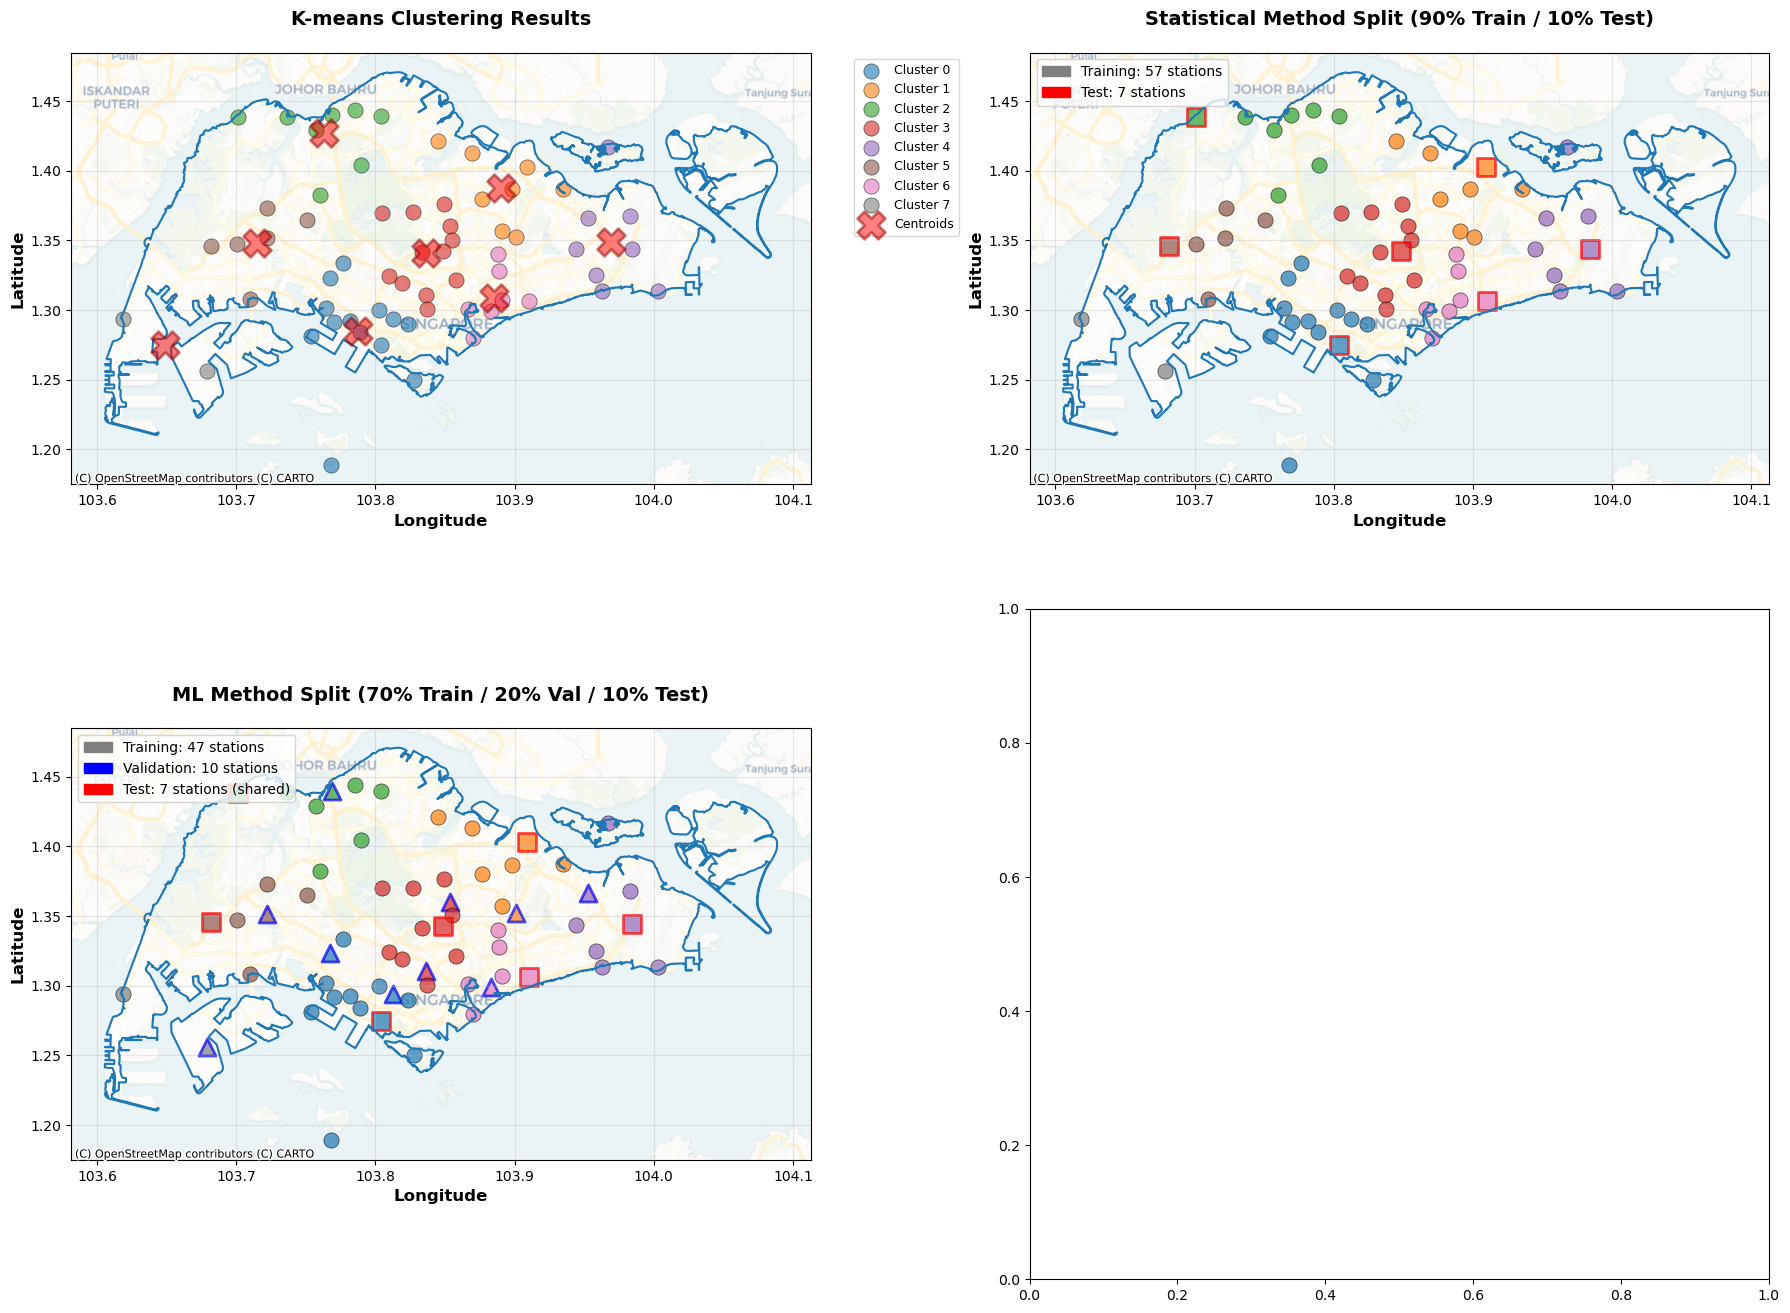

{'statistical': {'train': array(['S92', 'S201', 'S50', 'S222', 'S203', 'S223', 'S230', 'S77',
       'S102', 'S71', 'S116', 'S60', 'S06', 'S220', 'S219', 'S29', 'S221',
       'S900', 'S209', 'S104', 'S64', 'S210', 'S66', 'S211', 'S227',
       'S40', 'S79', 'S08', 'S216', 'S123', 'S213', 'S90', 'S109', 'S217',
       'S111', 'S69', 'S07', 'S94', 'S207', 'S107', 'S84', 'S24', 'S208',
       'S106', 'S228', 'S218', 'S121', 'S229', 'S33', 'S119', 'S215',
       'S43', 'S78', 'S214', 'S108', 'S115', 'S117'], dtype='<U4'), 'test': array(['S226', 'S81', 'S112', 'S88', 'S224', 'S44', 'S113'], dtype='<U4')}, 'ml': {'train': array(['S50', 'S230', 'S116', 'S92', 'S203', 'S222', 'S71', 'S223', 'S60',
       'S102', 'S900', 'S220', 'S221', 'S29', 'S209', 'S219', 'S227',
       'S64', 'S40', 'S211', 'S104', 'S66', 'S69', 'S08', 'S07', 'S79',
       'S90', 'S213', 'S217', 'S123', 'S109', 'S106', 'S208', 'S24',
       'S84', 'S207', 'S107', 'S218', 'S33', 'S228', 'S121', 'S215',
       'S108', 'S119

In [10]:
split_info = stratified_spatial_sampling_dual(weather_station_locations, seed=123)
print(split_info)

data['general_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in general_station]
data['general_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in general_station]
data['general_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['general_station'].train_mask, data['general_station'].val_mask)]

data['rainfall_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in rainfall_station]
data['rainfall_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in rainfall_station]
data['rainfall_station'].test_mask = [1 if (x == 0 and y == 0) else 0 for x,y in zip(data['rainfall_station'].train_mask, data['rainfall_station'].val_mask)]

print(data)

# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.

In [11]:
import math
def get_distance(a, b):
  return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2 )

['S109', 'S50', 'S107', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06', 'S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
[[  1.3764  103.8492 ]
 [  1.3337  103.7768 ]
 [  1.3135  103.9625 ]
 [  1.34583 103.68166]
 [  1.4168  103.9673 ]
 [  1.31055 103.8365 ]
 [  1.189   103.768  ]
 [  1.25    103.8279 ]
 [  1.44387 103.78538]
 [  1.3399  103.8878 ]
 [  1.29377 103.61843]
 [  1.37288 103.72244]
 [  1.256   103.679  ]
 [  1.281   103.754  ]
 [  1.3524  103.9007 ]
 [  1.3415  103.8334 ]
 [  1.3701  103.8271 ]
 [  1.43854 103.70131]
 [  1.30648 103.9104 ]
 [  1.30105 103.8666 ]
 [  1.3214  103.8577 ]
 [  1.32311 103.76714]
 [  1.29164 1

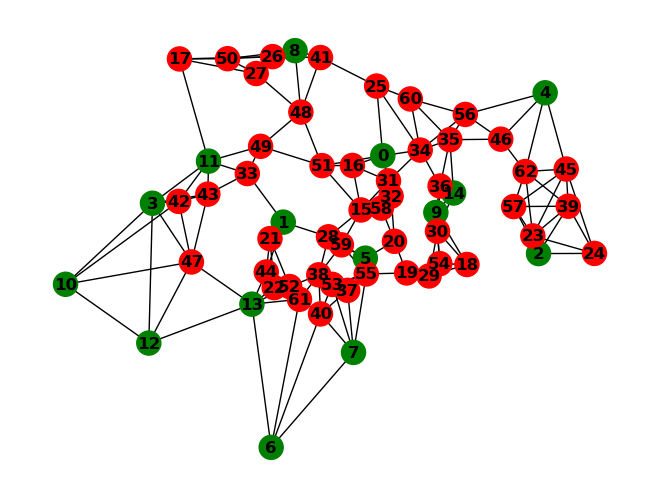

In [12]:
#variable to determine number of neighbours per node
import networkx as nx
from sklearn.neighbors import NearestNeighbors
K = 4

ids = general_station + rainfall_station
print(ids)

coordinates = []
for id in ids:
  coordinates.append(weather_station_locations[id])
coords = np.array(coordinates)

print(coords)
knn = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree')
knn.fit(coords)

distances, indices = knn.kneighbors(coords)

G = nx.Graph()

edges = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
    }

edge_attributes = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
}

#add station coordinates for nx plotting
for idx, station in enumerate(general_station + rainfall_station):
  G.add_node(idx, pos=(weather_station_locations[station][1], weather_station_locations[station][0]))
color_map = ['green' for i in range(len(general_station))] + ['red' for i in range(len(rainfall_station))]

for idx, row in enumerate(indices):
  origin = row[0]
  
  for n in row[1:]: 
    G.add_edge(origin, n)
    if ids[origin] in rainfall_station:
      start_id = rainfall_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['rainfall_to_rainfall'].append([start_id, end_id])
        edge_attributes['rainfall_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['rainfall_to_general'].append([start_id, end_id])
        edge_attributes['rainfall_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
    else:
      start_id = general_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['general_to_rainfall'].append([start_id, end_id])
        edge_attributes['general_to_rainfall'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])
      else:
        end_id = general_station.index(ids[n])
        edges['general_to_general'].append([start_id, end_id])
        edge_attributes['general_to_general'].append([get_distance(weather_station_locations[ids[origin]], weather_station_locations[ids[n]])])

print(G)
print(len(list(nx.connected_components(G))))
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_color = color_map, with_labels=True, font_weight='bold')

for key, val in edges.items():
  xarr = []
  yarr = []
  for x, y in val:
    xarr.append(x)
    yarr.append(y)
  edges[key] = [xarr, yarr]


data['general_station', 'gen_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['general_to_rainfall'], dtype=torch.int64)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index = torch.tensor(edges['rainfall_to_general'], dtype=torch.int64)
data['general_station', 'gen_to_gen', 'general_station'].edge_index = torch.tensor(edges['general_to_general'], dtype=torch.int64)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['rainfall_to_rainfall'], dtype=torch.int64)

data['general_station', 'gen_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['general_to_rainfall'], dtype=torch.float32)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_general'], dtype=torch.float32)
data['general_station', 'gen_to_gen', 'general_station'].edge_attr = torch.tensor(edge_attributes['general_to_general'], dtype=torch.float32)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_attr = torch.tensor(edge_attributes['rainfall_to_rainfall'], dtype=torch.float32)

print(data)

# Creating the GNN

In [13]:
from models.gnn import HeteroGNN, HeteroGNN2, HeteroSAGEGNN, HeteroGCNGNN

model = HeteroGNN(hidden_channels=8, out_channels=1,
                  num_layers=5)

model.to(device='cuda' if torch.cuda.is_available() else 'cpu')

HeteroGNN(
  (convs): ModuleList(
    (0-4): 5 x HeteroConv(num_relations=4)
  )
  (lin_rainfall): Linear(8, 1, bias=True)
  (lin_general): Linear(8, 1, bias=True)
)

In [14]:
import tqdm
import torch.nn.functional as F
def collate_temporal_graphs(batch):
  gen_x = torch.stack([item['gen_x'] for item in batch])
  rain_x = torch.stack([item['rain_x'] for item in batch])
  gen_y = torch.stack([item['gen_y'] for item in batch])
  rain_y = torch.stack([item['rain_y'] for item in batch])

  metastation_mask = batch[0]['metastation_mask']
  rainfallstation_mask = batch[0]['rainfallstation_mask']
  edge_index_dict = batch[0]['edge_index_dict']
  edge_attribute_dict = batch[0]['edge_attr_dict']

  return {
      'gen_x': gen_x,
      'rain_x': rain_x,
      'gen_y': gen_y,
      'rain_y': rain_y,
      'metastation_mask': metastation_mask,
      'rainfallstation_mask': rainfallstation_mask,
      'edge_index_dict': edge_index_dict,
      'edge_attr_dict': edge_attribute_dict
  }

def train_epoch(model, data, dataloader, optimizer, device):  
  model.train()
  losses = []

  charge_bar = tqdm.tqdm(dataloader, desc='training')
  '''
  This is fake batching... AI suggested doing it before I realised it did nothing...
  Currently a lot of copying of data structure. Might be able to do optimization with this.
  '''
  for batch in charge_bar:
      # reset gradients
      optimizer.zero_grad()

      edge_index_dict = batch["edge_index_dict"]
      edge_attribute_dict = batch["edge_attr_dict"]

      for i in range(batch['gen_x'].shape[0]):

          train_metastation_mask = torch.tensor(batch['metastation_mask'], dtype=torch.bool).to(device)
          train_rainfallstation_mask = torch.tensor(batch['rainfallstation_mask'], dtype=torch.bool).to(device)
          step_loss = []

          training_metastation_indices = train_metastation_mask.nonzero(as_tuple=False)
          training_rainfallstation_indices = train_rainfallstation_mask.nonzero(as_tuple=False)
          gen_x = batch['gen_x']  # [batch_size, num_gen_nodes, gen_features]
          rain_x = batch['rain_x']  # [batch_size, num_rain_nodes, rain_features]
          gen_y = batch['gen_y']
          rain_y = batch['rain_y']

          #Start by indiviually masking metastations
          for idx in training_metastation_indices:
              gen_x_masked=gen_x[i].clone()
              rain_x_masked=rain_x[i].clone()
      
              gen_x_masked[~train_metastation_mask.bool()] = 0
              rain_x_masked[~train_rainfallstation_mask.bool()] = 0
              gen_x_masked[idx, 0] = 0 #mask only the first value which corresponds to the rainfall value

              x_dict = {
              'general_station': gen_x_masked,
              'rainfall_station': rain_x_masked,
              }
              optimizer.zero_grad()
              out = model(x_dict, edge_index_dict, edge_attribute_dict)

              # Model prediction
              gen_predictions = out['general_station'][idx]
              gen_actual = gen_y[i][idx]

              training_loss = F.mse_loss(gen_predictions, gen_actual) 
              step_loss.append(training_loss)

          #Indiviually mask rain stations
          for idx in training_rainfallstation_indices:
              gen_x_masked=gen_x[i].clone()
              rain_x_masked=rain_x[i].clone()
      
              #Mask stations that are not training stations
              gen_x_masked[~train_metastation_mask.bool()] = 0
              rain_x_masked[~train_rainfallstation_mask.bool()] = 0
              #Mask the selected rainfall station
              rain_x_masked[idx, 0] = 0

              x_dict = {
              'general_station': gen_x_masked,
              'rainfall_station': rain_x_masked,
              }

              optimizer.zero_grad()
              out = model(x_dict, edge_index_dict, edge_attribute_dict)

              # Model prediction
              rain_predictions = out['rainfall_station'][idx]
              rainfall_actual = rain_y[i][idx]

              training_loss = F.mse_loss(rain_predictions, rainfall_actual)
              step_loss.append(training_loss)
          
          loss = torch.stack(step_loss).mean()
          losses.append(loss.detach())

          #backpropagate
          loss.backward()

          # Update weights
          optimizer.step()


  losses = torch.stack(losses).mean().item()

  return losses


'''
Below is the code for the sampling method if we wanna use it later
'''
# def train_epoch(model, data, dataloader, optimizer, device):
#   model.train()
#   total_training_loss = 0

#   train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
#   train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

#   test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
#   test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)

#   val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
#   val_rain_mask = torch.tensor(data['rainfall_station'].val_mask, dtype=torch.bool).to(device)

#   edge_index_dict = {
#     key:val.to(device) for key, val in data.edge_index_dict.items()
#   }

#   edge_attribute_dict = {
#     key:val.to(device) for key, val in data.edge_attr_dict.items()
#   }
#   for batch in tqdm.tqdm(dataloader, desc="training"):
#     gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
#     rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
#     gen_y = batch['gen_y'].to(device)
#     rain_y = batch['rain_y'].to(device)

#     batch_size = gen_x.shape[0]

#     batch_loss = 0.0
#     count = 0
#     for i in range(batch_size):
#       training_metastation_indices = train_gen_mask.nonzero(as_tuple=False)
#       training_rainfallstation_indices = train_rain_mask.nonzero(as_tuple=False)
#       sampling_ratio = 0.8

#       for idx in range(5):
#         # Create mask for the stations whose values we want to predict and not use as input
#         # Sampling is done instead of training node by node just to make it train through epochs faster        
#         samples = math.floor((training_metastation_indices.numel() + training_rainfallstation_indices.numel()) * sampling_ratio)
#         mask_positions = torch.randperm(training_metastation_indices.numel() + training_rainfallstation_indices.numel())[0:samples]
#         metastation_indices = training_metastation_indices[mask_positions[mask_positions < training_metastation_indices.numel()]].flatten()
#         rainfallstation_indices = training_rainfallstation_indices[mask_positions[mask_positions >= training_metastation_indices.numel()] - training_metastation_indices.numel()].flatten()

#         gen_x_masked=gen_x[i].clone()
#         rain_x_masked=rain_x[i].clone()
  
#         gen_x_masked[val_gen_mask] = 0
#         rain_x_masked[val_rain_mask] = 0
#         gen_x_masked[test_gen_mask] = 0
#         rain_x_masked[test_rain_mask] = 0
#         gen_x_masked[metastation_indices] = 0
#         rain_x_masked[rainfallstation_indices] = 0

#         x_dict = {
#           'general_station': gen_x_masked,
#           'rainfall_station': rain_x_masked,
#         }
#         # print(x_dict)
#         optimizer.zero_grad()
#         out = model(x_dict, edge_index_dict, edge_attribute_dict)


#         gen_predictions = out['general_station'][metastation_indices]
#         rain_predictions = out['rainfall_station'][rainfallstation_indices]
#         gen_actual = gen_y[i][metastation_indices]
#         rainfall_actual = rain_y[i][rainfallstation_indices]

#         #Deals with case that all station of one type is masked and tensor is [] causing nan
#         if metastation_indices.numel() == 0:
#           gen_predictions = torch.zeros(1, device=device)
#           gen_actual= torch.zeros(1, device=device)
#         if rainfallstation_indices.numel() == 0:
#           rain_predictions = torch.zeros(1, device=device)
#           rainfall_actual = torch.zeros(1, device=device)
          

#         training_loss = F.mse_loss(gen_predictions, gen_actual) + F.mse_loss(rain_predictions, rainfall_actual)
#         batch_loss += training_loss
#         count += rain_predictions.numel() + gen_predictions.numel()

#     batch_loss = batch_loss / count
#     batch_loss.backward()
#     optimizer.step()
#     total_training_loss += batch_loss.item()
 
#   return total_training_loss/len(dataloader)


'\nBelow is the code for the sampling method if we wanna use it later\n'

In [15]:
def validate(model, data, dataloader, device):
  total_validation_loss = 0

  val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
  val_rain_mask = torch.tensor(data['rainfall_station'].val_mask, dtype=torch.bool).to(device)
  test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
  test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)
  train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
  train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }
  edge_attr_dict = {
    key:val.to(device) for key, val in data.edge_attr_dict.items()
  }
  for batch in tqdm.tqdm(dataloader, desc="validation"):
    gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
    rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
    gen_y = batch['gen_y'].to(device)
    rain_y = batch['rain_y'].to(device)

    batch_size = gen_x.shape[0]

    batch_loss = 0
    for i in range(batch_size):
      gen_x_masked=gen_x[i].clone()
      rain_x_masked=rain_x[i].clone()

      gen_x_masked[test_gen_mask] = 0
      rain_x_masked[test_rain_mask] = 0
      gen_x_masked[train_gen_mask] = 0
      rain_x_masked[train_rain_mask] = 0
      x_dict = {
        'general_station': gen_x_masked,
        'rainfall_station': rain_x_masked
      }
      out = model(x_dict, edge_index_dict, edge_attr_dict)


      gen_predictions = out['general_station'][val_gen_mask]
      rain_predictions = out['rainfall_station'][val_rain_mask]


      validation_loss = F.mse_loss(gen_predictions, gen_y[i][val_gen_mask]) + F.mse_loss(rain_predictions, rain_y[i][val_rain_mask])
      
  
      batch_loss += validation_loss.item()
    total_validation_loss += batch_loss
 
  return total_validation_loss/len(dataloader)

-----EPOCH: 1-----


validation: 100%|██████████| 546/546 [00:11<00:00, 48.17it/s]


Train Loss: 15.0653
Validation Loss: 133.8510
-----EPOCH: 2-----


validation: 100%|██████████| 546/546 [00:11<00:00, 47.91it/s]


Train Loss: 12.6802
Validation Loss: 123.3518
-----EPOCH: 3-----


validation: 100%|██████████| 546/546 [00:10<00:00, 50.18it/s]


Train Loss: 14.0267
Validation Loss: 134.8586
-----EPOCH: 4-----


validation: 100%|██████████| 546/546 [00:10<00:00, 49.85it/s]


Train Loss: 11.8567
Validation Loss: 135.8781
-----EPOCH: 5-----


validation: 100%|██████████| 546/546 [00:10<00:00, 49.93it/s]


Train Loss: 13.5692
Validation Loss: 129.5746
-----EPOCH: 6-----


validation: 100%|██████████| 546/546 [00:11<00:00, 48.43it/s]


Train Loss: 13.2790
Validation Loss: 138.0706
-----EPOCH: 7-----


validation: 100%|██████████| 546/546 [00:11<00:00, 49.38it/s]

Early stop loss
Training took 3899.3676810264587 seconds over 7 epochs


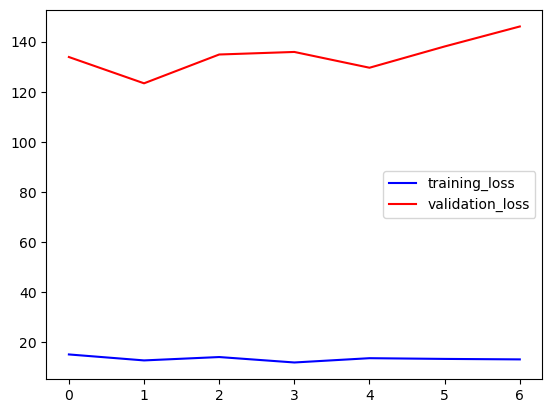

In [16]:
import torch
import torch.nn.functional as F
import random 
import tqdm as tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

#set seeds
seed=123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


batch_size=16
train_dataset = WeatherGraphDataset(data, mode='train')
val_dataset = WeatherGraphDataset(data, mode='val')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(
  train_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)
test_loader = DataLoader(
  val_dataset,
  batch_size=batch_size,
  shuffle=False,
  collate_fn=collate_temporal_graphs
)

optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
training_loss_arr = []
validation_loss_arr = []
early = 0
mini = 1000
stopping_condition = 5
epochs=0

training_start = time.time()
for i in range(20):
  print(f'-----EPOCH: {i + 1}-----')
  train_loss = train_epoch(model, data, train_loader, optimizer, device)
  validation_loss = validate(model, data, test_loader, device)
  training_loss_arr.append(train_loss)
  validation_loss_arr.append(validation_loss)
  if mini >= validation_loss:
    mini = validation_loss
    early = 0
  else:
    early += 1
  epochs+=1
  if early >= stopping_condition:
    print("Early stop loss")
    break

  print(f"Train Loss: {train_loss:.4f}")
  print(f"Validation Loss: {validation_loss:.4f}")

training_end = time.time()

print(f"Training took {training_end - training_start} seconds over {epochs} epochs")
plt.plot(training_loss_arr, label='training_loss', color='blue')
plt.plot(validation_loss_arr, label='validation_loss', color='red')
plt.legend()


In [17]:
total_params = sum(param.numel() for param in model.parameters())
print(total_params)
print(list(param for param in model.parameters()))



1138
[Parameter containing:
tensor([[-0.2221,  0.1687, -0.3811,  0.3278, -0.3251],
        [-0.3556, -0.2826,  0.2025, -0.1652,  0.1674],
        [-0.3796, -0.2713, -0.1642, -0.0879, -0.3412],
        [ 0.2928, -0.1055,  0.1436,  0.3162,  0.0833],
        [ 0.1223,  0.4317, -0.2017,  0.1417, -0.1990],
        [ 0.3196,  0.3572, -0.4123,  0.3818,  0.2136],
        [ 0.1949,  0.1841,  0.3718, -0.0590, -0.3782],
        [-0.1283, -0.3150,  0.0296, -0.0835, -0.2399]], requires_grad=True), Parameter containing:
tensor([-0.0407,  0.4237, -0.0353,  0.0142, -0.0697,  0.0703,  0.3985,  0.2735],
       requires_grad=True), Parameter containing:
tensor([[ 0.1587,  0.0972,  0.1054,  0.1728, -0.0578],
        [-0.4156, -0.2766,  0.3817,  0.0267, -0.3623],
        [ 0.0705,  0.3695, -0.4226, -0.3011, -0.1781],
        [ 0.0180, -0.1043, -0.0491, -0.4360,  0.2094],
        [ 0.3925,  0.2734, -0.3167, -0.3605,  0.1857],
        [ 0.0100,  0.1833, -0.4370, -0.0267,  0.3154],
        [ 0.2075,  0.0163, 

In [18]:
from scipy.stats import pearsonr

def test_model():
  model.eval()
  total_rmse = 0

  plot_preds = np.array([])
  plot_actual = np.array([])

  test_dataset = WeatherGraphDataset(data, mode='val')

  val_gen_mask = torch.tensor(data['general_station'].val_mask, dtype=torch.bool).to(device)
  val_rain_mask = torch.tensor([0 for _ in data['rainfall_station'].val_mask], dtype=torch.bool).to(device)
  test_gen_mask = torch.tensor(data['general_station'].test_mask, dtype=torch.bool).to(device)
  test_rain_mask = torch.tensor(data['rainfall_station'].test_mask, dtype=torch.bool).to(device)
  train_gen_mask = torch.tensor(data['general_station'].train_mask, dtype=torch.bool).to(device)
  train_rain_mask = torch.tensor(data['rainfall_station'].train_mask, dtype=torch.bool).to(device)

  print(test_gen_mask)

  edge_index_dict = {
    key:val.to(device) for key, val in data.edge_index_dict.items()
  }

  edge_attr_dict = {
    key:val.to(device) for key, val in data.edge_attr_dict.items()
  }

  dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_temporal_graphs
  )

  count = 0
  with torch.no_grad():
    for batch in tqdm.tqdm(dataloader, desc="testing"):
      gen_x = batch['gen_x'].to(device)  # [batch_size, num_gen_nodes, gen_features]
      rain_x = batch['rain_x'].to(device)  # [batch_size, num_rain_nodes, rain_features]
      gen_y = batch['gen_y'].to(device)
      rain_y = batch['rain_y'].to(device)

      batch_size = gen_x.shape[0]

      batch_rmse = 0
      for i in range(batch_size):

        gen_x_masked=gen_x[i].clone()
        rain_x_masked=rain_x[i].clone()

        gen_x_masked[val_gen_mask] = 0
        rain_x_masked[val_rain_mask] = 0
        gen_x_masked[train_gen_mask] = 0
        rain_x_masked[train_rain_mask] = 0
        x_dict = {
          'general_station': gen_x_masked,
          'rainfall_station': rain_x_masked
        }

        out = model(x_dict, edge_index_dict, edge_attr_dict)

        gen_predictions = out['general_station'][test_gen_mask]
        rain_predictions = out['rainfall_station'][test_rain_mask]

        gen_targets = gen_y[i][test_gen_mask]
        rain_targets = rain_y[i][test_rain_mask]

        plot_preds = np.concatenate((plot_preds, gen_predictions.detach().numpy().flatten(), rain_predictions.detach().numpy().flatten()))
        plot_actual = np.concatenate((plot_actual, gen_targets.detach().numpy().flatten(), rain_targets.detach().numpy().flatten()))

        gen_MSE_arr = (gen_predictions - gen_targets) ** 2
        rain_MSE_arr = (rain_predictions - rain_targets) ** 2

        all_squared_errors = torch.cat([gen_MSE_arr, rain_MSE_arr])
        test_rmse = torch.sqrt(torch.mean(all_squared_errors))

        batch_rmse += test_rmse.item()
        count += 1

      total_rmse += batch_rmse
 
  plt.scatter(x=plot_actual, y=plot_preds)
  plot_bound = max(np.nanmax(plot_actual).astype(int),np.nanmax(plot_preds).astype(int))
  plt.plot(np.linspace(0,plot_bound,100),
            np.linspace(0,plot_bound,100))
  plt.xlabel("actual rainfall")
  plt.ylabel("predicted rainfall")

  mask = ~np.isnan(plot_actual)
  pearson_r_global, pearson_p_global = pearsonr(plot_actual[mask], plot_preds[mask])

  print(f"Pearson correlation: {pearson_r_global}")
  return total_rmse/count

tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False])


testing: 100%|██████████| 8736/8736 [00:10<00:00, 862.98it/s]


Pearson correlation: 0.9004020584135004
TEST RMSE: 0.8395298126702889


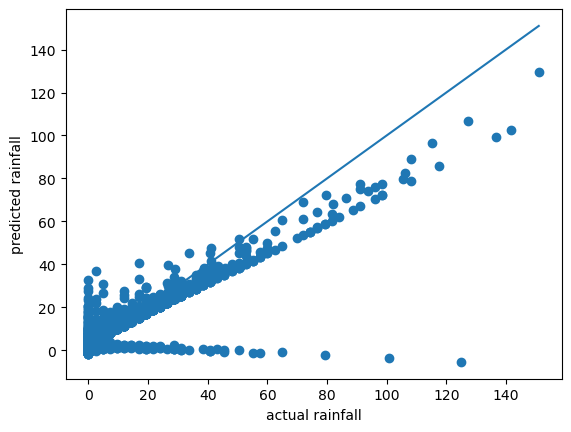

In [19]:
RMSE = test_model()
print(f"TEST RMSE: {RMSE}")

# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [20]:
test_event_data = weather_station_df_pivot.iloc[593:602]
print(test_event_data)
test_data = data.clone()

test_general_station_data = {}
test_rainfall_station_data = {}

for station in test_event_data.columns.get_level_values(1).unique():
    station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      test_general_station_data[station] = station_cols.values 
    else:
      test_rainfall_station_data[station] = station_cols.values[:, 0:1]
# print(test_general_station_data)
# print(test_rainfall_station_data)

test_general_station_features = []
test_rainfall_station_features = []

for station in general_station:
  if station in test_general_station_data:
    station_feat = test_general_station_data[station]
    test_general_station_features.append(station_feat)

for station in rainfall_station:
  if station in test_rainfall_station_data:
    station_feat = test_rainfall_station_data[station]
    test_rainfall_station_features.append(station_feat)

# print(test_general_station_features)
# print(test_rainfall_station_features)

test_data['general_station'].x = torch.tensor(np.array(test_general_station_features).transpose(1,0,2), dtype=torch.float)
test_data['general_station'].y = torch.tensor(np.array(test_general_station_features)[:, :,0:1].transpose(1,0,2), dtype=torch.float)
test_data['rainfall_station'].x = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float) 
test_data['rainfall_station'].y = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float)  

out = model(test_data.x_dict, test_data.edge_index_dict, test_data.edge_attr_dict)
gen_out = out['general_station'].detach().numpy()
rain_out = out['rainfall_station'].detach().numpy()

out_np = np.concatenate([gen_out, rain_out], axis=1)

                    rain_rate                                               \
gid                       S06  S07  S08 S102 S104 S106 S107 S109 S111 S112   
time_sgt                                                                     
2025-02-05 04:15:00       2.4  0.0  2.4  NaN  0.0  4.8  4.8  0.0  2.4  2.4   
2025-02-05 04:30:00       2.4  2.4  2.4  NaN  0.0  4.8  4.8  2.4  0.0  2.4   
2025-02-05 04:45:00       2.4  2.4  2.4  NaN  2.4  4.8  7.2  2.4  2.4  0.0   
2025-02-05 05:00:00       2.4  0.0  2.4  NaN  0.0  7.2  7.2  2.4  2.4  2.4   
2025-02-05 05:15:00       4.8  0.0  0.0  NaN  0.0  4.8  4.8  2.4  0.0  2.4   
2025-02-05 05:30:00       4.8  2.4  2.4  NaN  0.0  4.8  4.8  2.4  2.4  2.4   
2025-02-05 05:45:00       4.8  0.0  0.0  NaN  2.4  4.8  4.8  2.4  0.0  0.0   
2025-02-05 06:00:00       2.4  0.0  2.4  NaN  0.0  2.4  2.4  0.0  0.0  0.0   
2025-02-05 06:15:00       2.4  2.4  2.4  NaN  2.4  2.4  2.4  2.4  0.0  0.0   

                     ... wind_speed                            

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/3265763813.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/3265763813.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_68896/3265763813.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolat

In [21]:
print(test_data.edge_index_dict)

{('general_station', 'gen_to_rain', 'rainfall_station'): tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
          4,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,
         10, 10, 11, 11, 11, 11, 12, 13, 13, 13, 13, 14, 14, 14],
        [16,  1, 17, 19,  6, 13, 29, 18,  8, 42, 24,  9, 27, 28, 32, 31, 30, 47,
         41, 40, 44,  5, 22, 25, 46, 25, 22, 38, 40, 11, 26, 12, 33, 15, 21, 39,
         32, 27, 28, 18, 27, 34, 32,  7, 29, 37, 46, 21, 15, 20]]), ('rainfall_station', 'rain_to_gen', 'general_station'): tensor([[ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 15, 16, 17, 18, 18,
         19, 20, 21, 21, 22, 24, 26, 27, 27, 28, 28, 29, 31, 32, 32, 33, 34, 35,
         36, 40, 42, 44],
        [ 0, 11,  9,  5,  1, 13,  2,  2,  0,  8,  8,  5,  9, 14,  0,  0, 11,  1,
          0, 14, 14,  9,  5,  2,  8,  3, 11, 11,  3, 13,  4,  3, 13,  8, 11,  8,
          0,  5,  2,  5]]), ('general_station', 'gen_to_gen', 'general_station'

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [22]:
print(out_np / 12)

[[[ 1.90645888e-01]
  [ 1.78791091e-01]
  [ 1.73411384e-01]
  [ 1.99456453e-01]
  [ 1.94164515e-01]
  [ 1.93510830e-01]
  [            nan]
  [            nan]
  [ 2.48937413e-01]
  [ 1.95931196e-01]
  [ 1.35944441e-01]
  [ 1.85782373e-01]
  [ 1.60925671e-01]
  [            nan]
  [ 1.85476705e-01]
  [ 3.20477903e-01]
  [ 4.71688718e-01]
  [ 5.19489586e-01]
  [ 1.19085886e-01]
  [ 5.26333630e-01]
  [ 5.03479958e-01]
  [ 2.15670615e-02]
  [ 2.31729597e-02]
  [ 9.82364953e-01]
  [ 5.25515497e-01]
  [ 6.46097004e-01]
  [ 4.54485416e-01]
  [ 2.35110939e-01]
  [ 7.37915933e-03]
  [ 4.80053991e-01]
  [ 1.30340740e-01]
  [ 2.42399797e-01]
  [ 4.80588198e-01]
  [ 3.76027785e-02]
  [ 7.46682405e-01]
  [ 5.32127559e-01]
  [ 1.19989634e-01]
  [ 4.37700748e-01]
  [ 1.04491174e-01]
  [ 9.98033226e-01]
  [            nan]
  [ 5.23287117e-01]
  [-1.18223333e-03]
  [ 4.30053435e-02]
  [-2.99453246e-03]
  [ 8.89693499e-01]
  [ 6.89739287e-01]
  [-1.15666294e-03]
  [ 2.24305436e-01]
  [ 2.89617721e-02]


In [23]:
from src.utils import *
from src.visualisation import *
radar_df = load_radar_dataset('radar_vis')

fig, ax = plt.subplots(3,3, figsize=(15,12), subplot_kw={'projection' : ccrs.PlateCarree()})

bounds_singapore = {
  'left': 103.6,
  'right': 104.1,
  'top': 1.5,
  'bottom': 1.188
}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

out_np = out_np / 12
for idx, timestamp in enumerate(out_np):
  output = {}
  count = 0
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1
  axi = ax[idx // 3][idx % 3]
  node_df = pd.Series(output)
  node_df = pandas_to_geodataframe(node_df)
  visualise_gauge_grid(node_df=node_df, ax=axi)
  improved_visualise_radar_grid(radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm)
  visualise_singapore_outline(ax=axi)

ModuleNotFoundError: No module named 'src.visualisation'

In [ ]:
original_rainfall_rates = weather_station_df_pivot.iloc[1773:1797].resample('15min').first()['rain_rate']


print(original_rainfall_rates)

In [ ]:
print(out)

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
  output = {}
  count = 0
  a_arr = []
  p_arr = []
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1

  for key, value in output.items():
    a_arr.append(original_rainfall_rates.iloc[idx][key])
    p_arr.append(output[key])
  a_arr = list(map(lambda x: float(x), a_arr))
  actual_arr.append(a_arr)
  pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
  error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])